In [11]:
options(future.globals.maxSize = 16000 * 1024^2)
library(Seurat)
library(dplyr)
library(ggplot2)
library(viridis)
source("../Scripts/functions.R")
source("../Scripts/plots.r")
options(repr.plot.width=10, repr.plot.height=10)

In [12]:
output <- "../Results/"  # Path to the folder in which to write the results
test       <- read.csv("../Results/celltypeAccuracies_CrossSpecies.csv", header=F) # accuracy results
umap_og       <- read.csv("../Results/umap_CrossSpecies.csv") # umap results
umap_og [umap_og ==TRUE]<-1
umap_og [is.na(umap_og)]<- 0

file_train <- "../Data/subsets/CrossSpecies_228_2/data_train.txt" # expression matrix training data
file_test  <- "../Data/processed/CrossSpecies/data_test.txt"  # expression matrix test data
meta_train <- read.csv("../Data/subsets/CrossSpecies_228_2/meta_train.txt") # meta data for the training data
meta_test  <- read.csv("../Data/processed/CrossSpecies/meta_test.txt") # meta data for the test data

celltypes <- c('B Cells','CD Intercalated Cell','Distal Tubules','Endothelial','Loop of Helene','Macrophage', 'Natural Killer Cells',
               'Proximal Tubule', "T Cells")
main_celltypes <- c('Endothelial','Loop of Helene', "Distal Tubules", "CD Intercalated Cell")
colnames(test) <- append(c("Method", "Version", "CellsPerCelltype", "SetNr"), celltypes)
test <- test[!(duplicated(test)),]
meta_train$type="train"
meta_test$type="test"
meta <- rbind(meta_train, meta_test)
meta$class_ <- as.factor(meta$class_)

translations <- setNames(c('B Cells','CD Intercalated Cell','Distal Tubules','Endothelial','Loop of Helene','Macrophage', 'Natural Killer Cells',
               'Proximal Tubule', "T Cells"), c("B_Cells", "CD_IC", "Distal_Tubules", "Endo", "Loop of Helene", "Macrophage", "NK_Cells", "PT", "T_Cells") )
meta$class_ <- stringr::str_replace_all(meta$class_, stringr::fixed(translations))

umap <- merge(umap_og, meta, by=c("id"),all = T)
rownames(umap) <- umap$id
methods <- c("Seurat", "CellID", "SCN", "ItClust", "MLP")
for(method in methods) umap <- get_percentage_predictions(umap,"CrossSpecies", method, 228)

umap_object <- prepare_umap(file_train = file_train, file_test = file_test, meta_data = umap, split = NULL)
umap_object$type[umap_object$type=="test"] <- "Query"
umap_object$type[umap_object$type=="train"] <- "Reference"

Warning message in data.table::fread(data, sep = ",", verbose = F):
“Detected 2052 column names but the data has 2053 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in data.table::fread(data, sep = ",", verbose = F):
“Detected 15693 column names but the data has 15694 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


An object of class Seurat 
12435 features across 17745 samples within 1 assay 
Active assay: RNA (12435 features, 0 variable features)


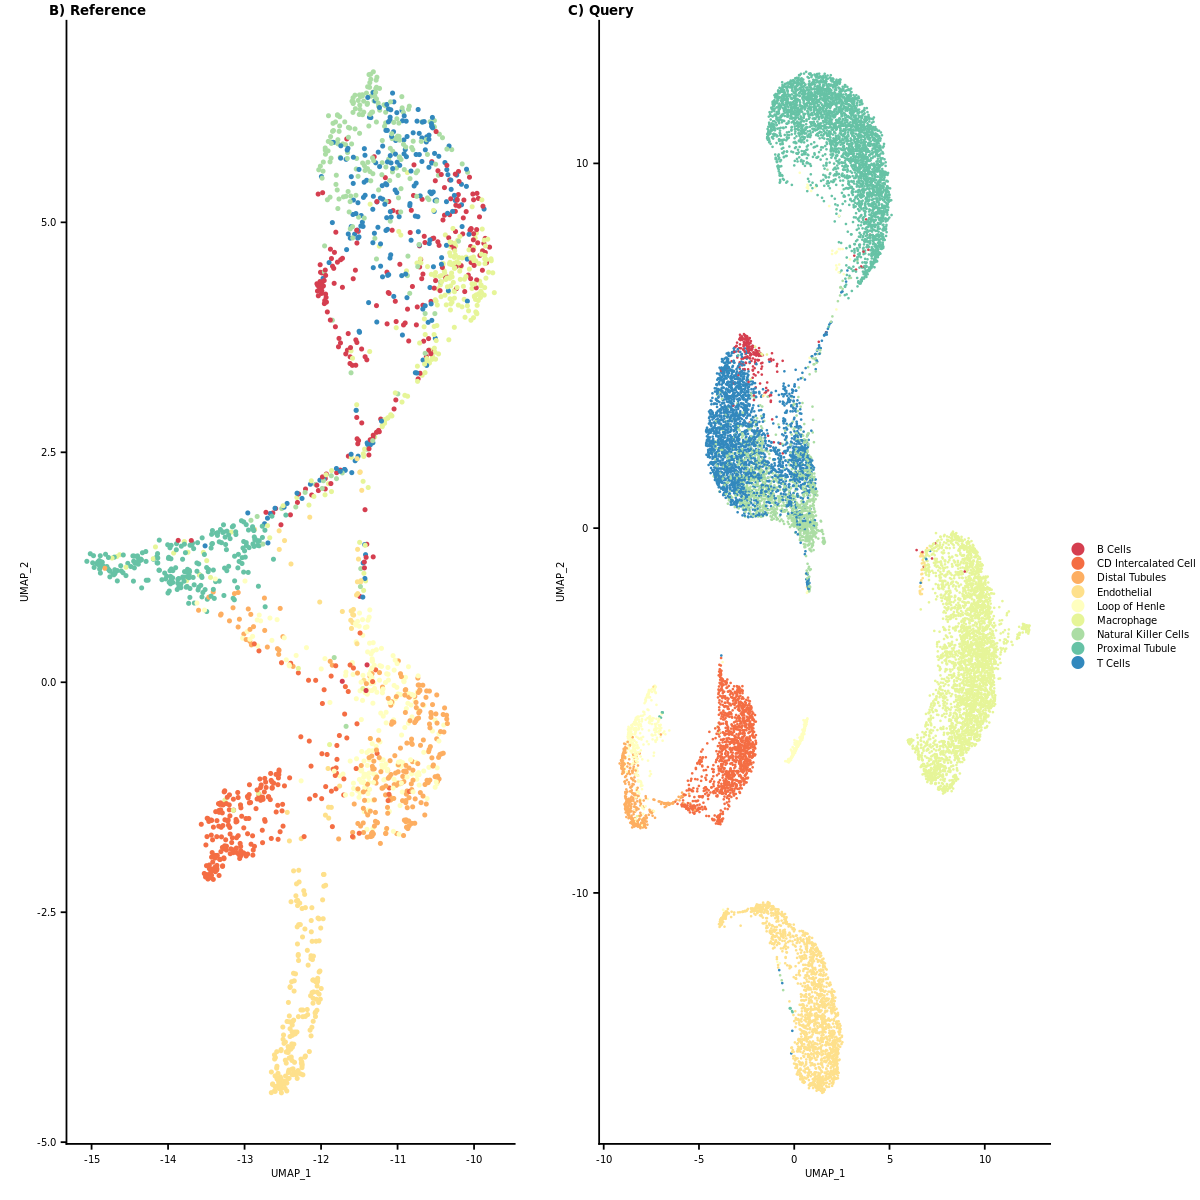

In [13]:
f2A = plot_umap(umap_object, c("class_"), NULL, "Spectral",1,1, umap_object$id[umap_object$type=="Reference"], legend_ncol = 1)
cells = umap_object$id[umap_object$type=="Query"]
f2B <- plot_umap(umap_object, c("class_"), NULL, "Spectral",1,1, cells, legend_ncol = 1)
#umap_object$type <- factor(umap_object$type, levels=c("train", "test"))
f2AB <- ggpubr::ggarrange(plotlist = append(f2A, f2B), common.legend = T, legend="right", labels=c("B) Reference", "C) Query"),  font.label = list(size = 8))
f2AB

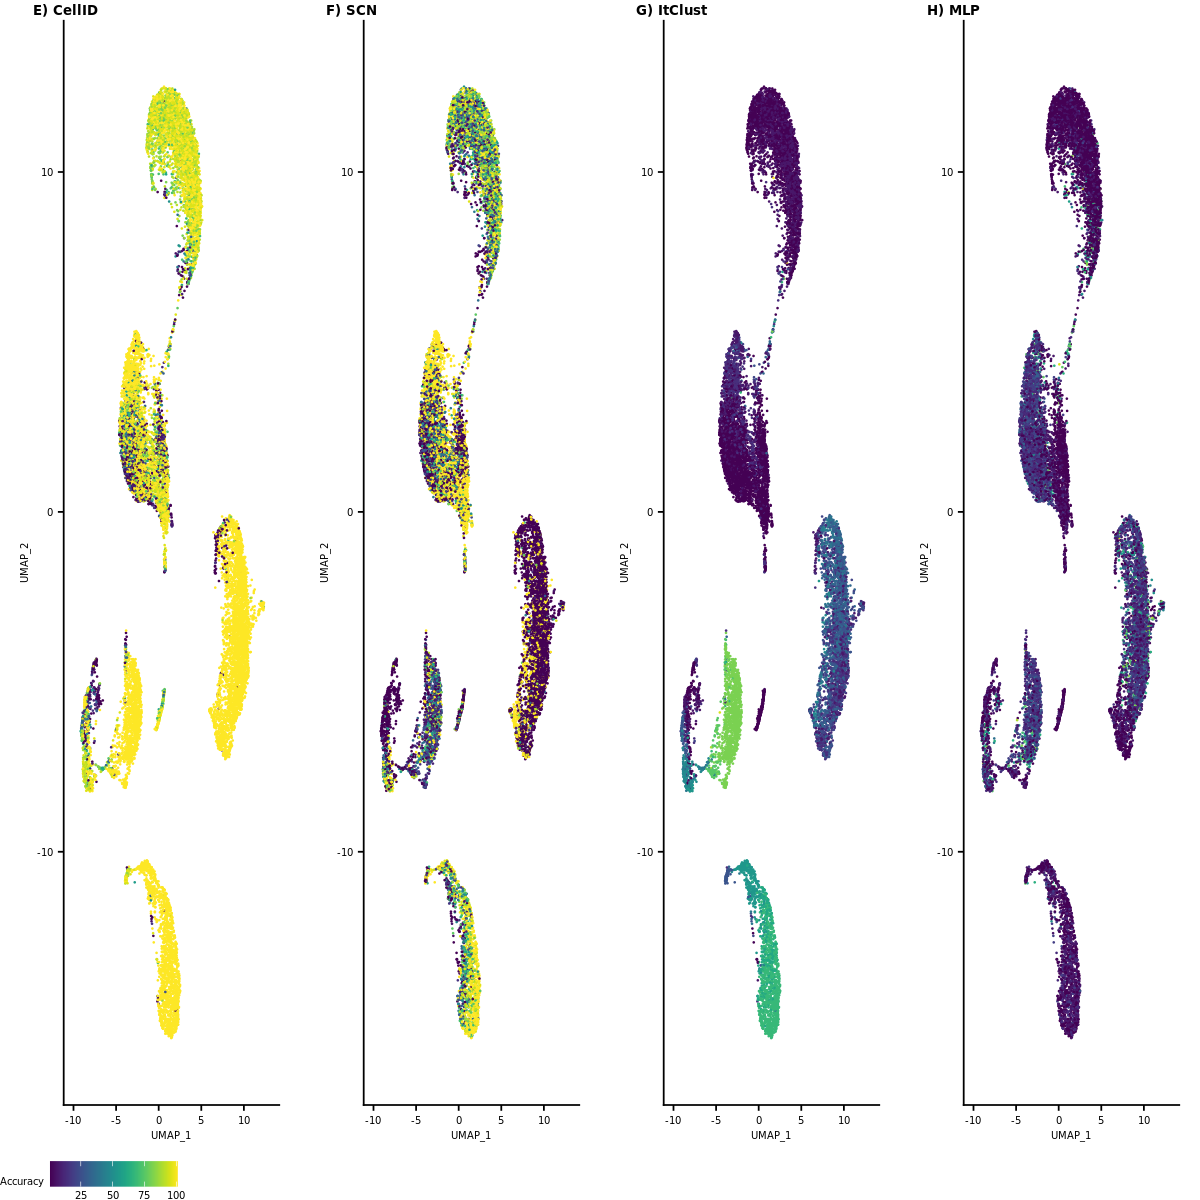

In [14]:
f2BF_list <-lapply(methods, function(method) plot_features(umap_object, method,cells, c("CrossSpecies_"), legend=T))
names(f2BF_list) <- methods
f2BF <- ggpubr::ggarrange(plotlist=f2BF_list[2:length(f2BF_list)] ,common.legend = T, legend = "bottom", ncol=4, nrow=1,
                        labels=c( "E) CellID", "F) SCN", "G) ItClust", "H) MLP"),  font.label = list(size = 8) )
f2BF

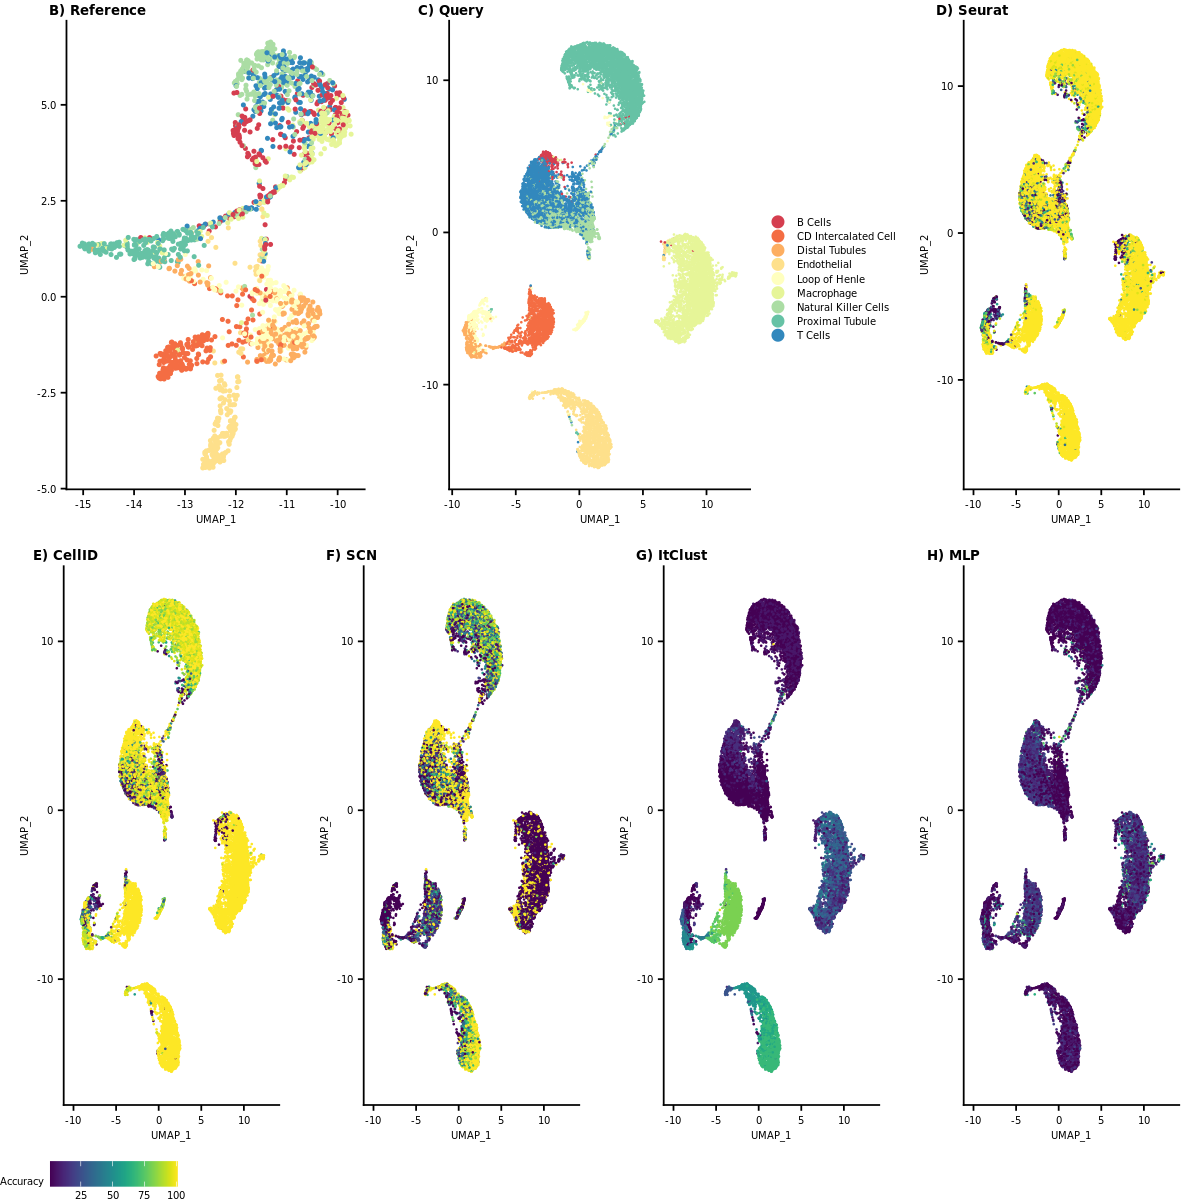

In [16]:
seurat <- ggpubr::ggarrange(plotlist=f2BF_list[1], ncol=1,nrow=1, labels=c("D) Seurat"),
                                                           font.label = list(size = 8), common.legend=T, legend="none") 
f2 <- ggpubr::ggarrange(ggpubr::ggarrange(f2AB, seurat, common.legend = F, ncol=2, widths = c(3,1)),
                        f2BF, common.legend = F, nrow=2,font.label = list(size = 8), heights=c(1,1.2))

#f2 <- ggpubr::ggarrange(f2AB,f2BF ,common.legend = T, legend = "bottom", ncol=1, nrow=2,  font.label = list(size = 8), heights = c(1,2.2),labels = c("A) Cell type distribution") )
                         
ggplot2::ggsave(paste0(output, "s3_crossSpecies_umap.png"), plot=f2, device = "png",
                dpi=350, width=178, height = 100,units = "mm",bg = "white")
f2